# Data

The dataset comes already with a train, validation and test split.

The training data contains 2000 images per class with 256x256 pixels per picture.
The validation set contains 100/200 images per class
and the testing data is filled with a random number
of images per class.

Since the project requires to have atleast 500 images per class and that 30% should be locked for the test set, 
we will only use the data contained in the training set and split it ourselves.

TODO: b) In the notebook, cite and describe your dataset properly (data source, pre-processing)


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #Workaround for kernel crash because multiple copies of the OpenMP runtime have been linked

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers


In [2]:
#Set os env variable. Only required if not already set.
os.environ["aiap_data_path"] = "C:/Users/mrcls/temp_dataset/animals/data"

In [3]:
data_path = os.environ["aiap_data_path"]
batch_size = 32
img_height = 64
img_width = 64
img_channels = 3 #RGB
shuffle_seed = 1234
test_data_ratio = 0.3
validation_data_ratio= 0.2
img_classes = [ #explicitly define the used classes to avoid errors
    "Cow",
    "Dog",
    "Elephant",
    "Gorilla",
    "Hippo",
    "Lizard",
    "Monkey",
    "Panda",
    "Tiger",
    "Zebra"
    ]


In [4]:
#Load the data and split
#A tf.data.Dataset object
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, #directory where data is located
    class_names=img_classes, #pass in names of classes
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True, #shuffle the data
    seed=shuffle_seed, #seed for the shuffling and transformations
    validation_split=test_data_ratio, #we reserve 30% of the data for the test set
    subset="both",
)
print("do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data")

Found 20000 files belonging to 10 classes.
Using 14000 files for training.
Using 6000 files for validation.
do not confuse the output here. we explicitly use the validation data as test data and split the training data again for the validation data


In [5]:
print("data variable contains:",len(data),"elements")
training_data= data[0]
test_data = data[1]
assert isinstance(training_data, tf.data.Dataset)
assert isinstance(test_data, tf.data.Dataset)

print("training data size:",training_data.cardinality())
print("test data size:", test_data.cardinality())
print("class names:", training_data.class_names)


data variable contains: 2 elements
training data size: tf.Tensor(438, shape=(), dtype=int64)
test data size: tf.Tensor(188, shape=(), dtype=int64)
class names: ['Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Panda', 'Tiger', 'Zebra']


In [6]:

training_data_size = sum(1 for _ in training_data)
print(training_data_size, "batches")
validation_data_size = int(validation_data_ratio * training_data_size)
print(validation_data_size, "batches")
validation_data = training_data.take(validation_data_size)
class_names = training_data.class_names
training_data = training_data.skip(validation_data_size)

438 batches
87 batches


{'_input_dataset': <BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, '_count': <tf.Tensor: shape=(), dtype=int64, numpy=87>, '_name': None, '_variant_tensor_attr': <tf.Tensor: shape=(), dtype=variant, value=<SkipDatasetOp::Dataset>>, '_graph_attr': <tensorflow.python.framework.ops.Graph object at 0x000001457D3DB7F0>, '_options_attr': <tensorflow.python.data.ops.options.Options object at 0x000001457E5AEAA0>}


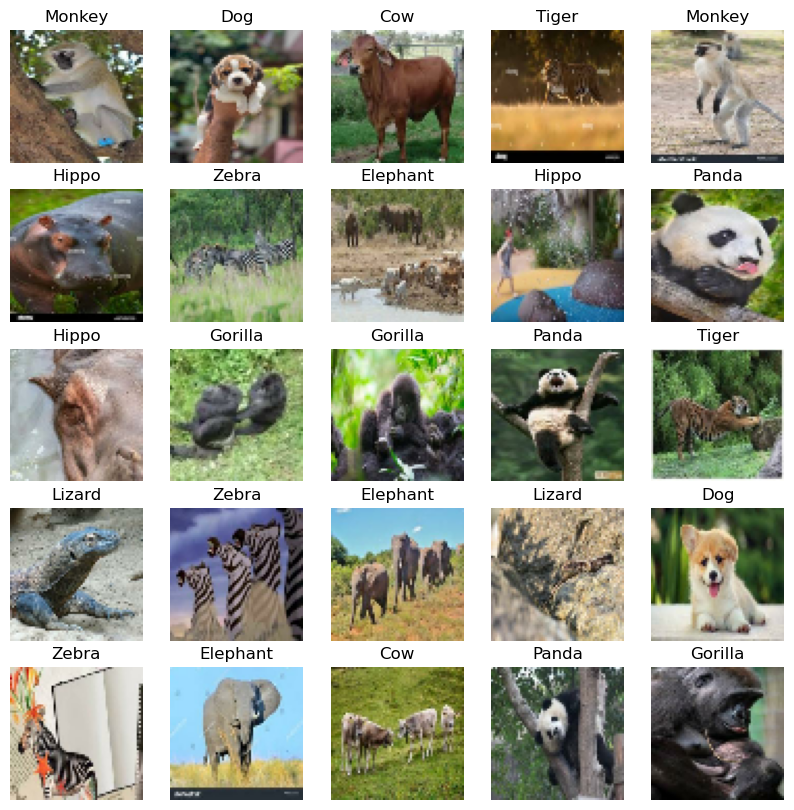

In [7]:
plt.figure(figsize=(10, 10))
print(vars(training_data))
for images, labels in training_data.take(1):
  for i in range(25):
    try:
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
    except Exception as e:
      print(f"Error at index {i}: {e}")

# Exploratory data analysis
Analyse and visualize your data set. How many samples per class do you have? Is the dataset 
balanced? Plot a few images. What is the range of values of the images? If it is [0 255] you need to 
scale or normalize the data

# Architecture 1
- 3 layers (without MaxPooling and Flatten)
- <2000 trainable parameters

In [8]:
simple_model = models.Sequential()
simple_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
simple_model.add(layers.MaxPooling2D((32, 32)))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(32, activation='relu'))
simple_model.add(layers.Dense(10))
simple_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,282
Trainable params: 2,282
Non-trainable params: 0
______________________________________________________

In [9]:
simple_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
# history dictionary for successive combined trainings
combined_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [236]:
# save history data to disk
import json
# Save the dictionary to disk using JSON
with open('combined_history_simple_model.json', 'w') as f:
    json.dump(combined_history, f)

In [13]:
# load history data from disk
import json

with open('combined_history_simple_model.json', 'r') as f:
    combined_history = json.load(f)

In [200]:
# train
history = simple_model.fit(training_data, epochs=20, 
                           validation_data=validation_data)
# Update the combined_history with the first training session
for key in combined_history.keys():
    combined_history[key].extend(history.history[key])

Epoch 1/20


351/351 [==============================] - 8s 22ms/step - loss: 1.5356 - accuracy: 0.4717 - val_loss: 1.6460 - val_accuracy: 0.4486
Epoch 2/20
351/351 [==============================] - 8s 21ms/step - loss: 1.5465 - accuracy: 0.4696 - val_loss: 1.6487 - val_accuracy: 0.4544
Epoch 3/20
351/351 [==============================] - 8s 21ms/step - loss: 1.5456 - accuracy: 0.4674 - val_loss: 1.6543 - val_accuracy: 0.4537
Epoch 4/20
351/351 [==============================] - 15s 39ms/step - loss: 1.5513 - accuracy: 0.4659 - val_loss: 1.6529 - val_accuracy: 0.4504
Epoch 5/20
351/351 [==============================] - 23s 61ms/step - loss: 1.5501 - accuracy: 0.4650 - val_loss: 1.6898 - val_accuracy: 0.4389
Epoch 6/20
351/351 [==============================] - 8s 20ms/step - loss: 1.5485 - accuracy: 0.4697 - val_loss: 1.6526 - val_accuracy: 0.4425
Epoch 7/20
351/351 [==============================] - 8s 21ms/step - loss: 1.5469 - accuracy: 0.4677 - val_loss: 1.6815 - val_accuracy: 0.4450
Epoch 8/

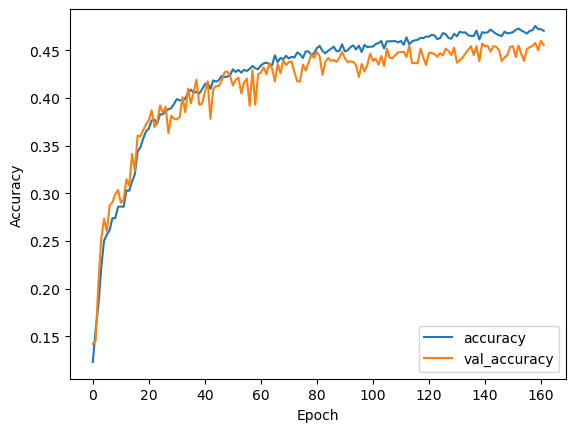

In [14]:
# plott accuracy
plt.plot(combined_history['accuracy'], label='accuracy')
plt.plot(combined_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
#test_loss, test_acc = simple_model.evaluate(test_data verbose=2)

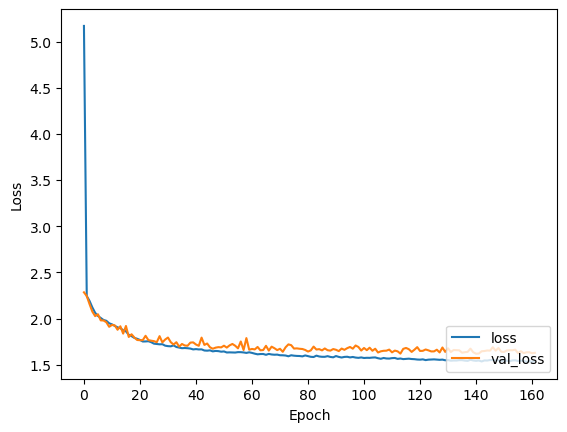

In [15]:
# plot error
plt.plot(combined_history['loss'], label = 'loss')
plt.plot(combined_history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [235]:
# save model to disk
simple_model.save("simple_model")

INFO:tensorflow:Assets written to: simple_model\assets


INFO:tensorflow:Assets written to: simple_model\assets


## Confusion matrix
of the validation data.
Make 3 different plots for 3 different values of the 
'normalize' parameter (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html )

In [17]:
# Make predictions using the simple_model and training_data
predictions = simple_model.predict(training_data)

# Get the true labels from the training_data
true_labels = []
for _, labels in training_data:
    true_labels.extend(labels.numpy())

# Convert the predictions to class labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Compute confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print(confusion_matrix)


351/351 [==============================] - 5s 10ms/step
tf.Tensor(
[[   0   89    0    0    0    0 1067    0    0    0]
 [   0  103    0    0    0    0 1024    0    0    0]
 [   0   81    0    0    0    0  979    0    0    0]
 [   0   72    0    0    0    0 1080    0    0    0]
 [   1   90    0    0    0    0 1023    0    0    0]
 [   0   96    0    0    0    0 1053    0    0    0]
 [   0   90    0    0    0    0 1039    0    0    0]
 [   0  106    0    0    0    0 1002    0    0    0]
 [   0   89    0    0    0    0 1026    0    0    0]
 [   0  102    0    0    0    0 1004    0    0    0]], shape=(10, 10), dtype=int32)


## Discussion
Avoid stride>kernel-size (do you see why?)
disscuss underfitting

# Architecture 2

In [34]:
complex_model = models.Sequential()
complex_model.add(layers.Conv2D(96, (9, 9), activation='relu', input_shape=(img_height, img_width, img_channels)))
complex_model.add(layers.Conv2D(256, (6, 6),activation='relu'))
complex_model.add(layers.Conv2D(256, (3, 3),activation='relu'))
complex_model.add(layers.Conv2D(256, (3, 3),activation='relu'))

#complex_model.add(layers.MaxPooling2D((3, 3), strides=2))
#complex_model.add(layers.Conv2D(384, (3, 3), activation='relu', padding="same"))
#complex_model.add(layers.Conv2D(384, (3, 3), activation='relu', padding="same"))
#complex_model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
#complex_model.add(layers.MaxPooling2D((3, 3), strides=2))
#complex_model.add(layers.Flatten())
#complex_model.add(layers.Dense(4096, activation='relu'))
#complex_model.add(layers.Dense(4096, activation='relu'))
#complex_model.add(layers.Dense(10))
complex_model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 56, 56, 96)        23424     
                                                                 
 conv2d_68 (Conv2D)          (None, 51, 51, 256)       884992    
                                                                 
 conv2d_69 (Conv2D)          (None, 49, 49, 256)       590080    
                                                                 
 conv2d_70 (Conv2D)          (None, 47, 47, 256)       590080    
                                                                 
Total params: 2,088,576
Trainable params: 2,088,576
Non-trainable params: 0
_________________________________________________________________


In [119]:
complex_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

complex_history = complex_model.fit(training_data, epochs=10, 
                           validation_data=validation_data)

Epoch 1/10


351/351 [==============================] - 28s 75ms/step - loss: 2.3713 - accuracy: 0.3126 - val_loss: 1.5847 - val_accuracy: 0.4591
Epoch 2/10
351/351 [==============================] - 27s 74ms/step - loss: 1.4602 - accuracy: 0.4983 - val_loss: 1.4039 - val_accuracy: 0.5277
Epoch 3/10
351/351 [==============================] - 27s 72ms/step - loss: 1.2004 - accuracy: 0.5921 - val_loss: 1.3174 - val_accuracy: 0.5657
Epoch 4/10
351/351 [==============================] - 25s 68ms/step - loss: 0.9721 - accuracy: 0.6711 - val_loss: 1.3554 - val_accuracy: 0.5747
Epoch 5/10
143/351 [===========>..................] - ETA: 13s - loss: 0.8785 - accuracy: 0.7026

KeyboardInterrupt: 

In [ ]:
plt.plot(complex_history.history['loss'], label = 'loss')
plt.plot(complex_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()